## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [223]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from time import time

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [122]:
# Opening JSON file 
filepath = 'complaints-2021-05-14_08_16.json'
f =  open(filepath) # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

## Data preparation

In [123]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [124]:
df.shape

(78313, 22)

In [125]:
#print the column names
cols = list(df.columns)
print(f'Number of columns in the dataset: {len(cols)}')

Number of columns in the dataset: 22


In [126]:
df[cols[:len(cols)//2]].head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A


In [127]:
df['_source.consumer_disputed'].value_counts()

_source.consumer_disputed
N/A    35683
No     33107
Yes     9523
Name: count, dtype: int64

In [128]:
df[cols[len(cols)//2:]].head()

,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,Didn't receive enough information to verify debt,Consent provided
2,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,Problem with rewards from credit card,Consent provided
3,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [129]:
# Creating a new list of columns.
new_col_names = [
    'index_name',
    'issue_type',
    'id',
    'score',
    'tags',
    'zipcode',
    'complaint_id',
    'issue',
    'received_date',
    'state',
    'consumer_disputed',
    'product',
    'company_response',
    'company',
    'submitted_via',
    'sent_to_company_date',
    'compnay_public_response',
    'sub_product',
    'timely_resolved',
    'complaint_text',
    'sub_issue',
    'consumer_consent_provided'
]

In [130]:
# Creating dictionary mapping old colum names with new ones.
new_cols = dict(zip(cols, new_col_names))

In [131]:
# Assign new column names and creating a new dataframe.
complaints_df = df.rename(columns=new_cols)

In [132]:
complaints_df.head()

,index_name,issue_type,id,score,tags,zipcode,complaint_id,issue,received_date,state,...,company_response,company,submitted_via,sent_to_company_date,compnay_public_response,sub_product,timely_resolved,complaint_text,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [133]:
# Let's analyze the complaint_text column.

# Get number of rows which has empty string or white spaces in complaint_text column.

num_rows_empty_complaints = len(complaints_df[complaints_df['complaint_text'].str.strip() == ''])
print(f'Number of rows with empty text in complaint_text column: {num_rows_empty_complaints}')

Number of rows with empty text in complaint_text column: 57241


In [134]:
#Assign nan in place of blanks in the complaints column
complaints_df.loc[complaints_df['complaint_text'].str.strip() == '','complaint_text'] = np.nan

In [135]:
complaints_df[complaints_df['complaint_text'].isna()].head()

,index_name,issue_type,id,score,tags,zipcode,complaint_id,issue,received_date,state,...,company_response,company,submitted_via,sent_to_company_date,compnay_public_response,sub_product,timely_resolved,complaint_text,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,NaN,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,NaN,Problem using a debit or ATM card,N/A


In [136]:
num_rows_empty_complaints = len(complaints_df[complaints_df['complaint_text'].str.strip() == ''])
num_rows_nan_complaints = len(complaints_df[complaints_df['complaint_text'].isna()])
print(f'Number of rows with empty text in complaint_text column: {num_rows_empty_complaints}')
print(f'Number of rows with NaN in complaint_text column: {num_rows_nan_complaints}')

Number of rows with empty text in complaint_text column: 0
Number of rows with NaN in complaint_text column: 57241


In [137]:
#Remove all rows where complaints column is nan
complaints_df = complaints_df[~complaints_df['complaint_text'].isna()]

In [138]:
# Number of rows in the dataset after removing rows where complaints column is nan.
print(f'Shape of dataset removing rows where complaints column is nan: {complaints_df.shape}')

Shape of dataset removing rows where complaints column is nan: (21072, 22)


In [139]:
# Let's take a glimpse of complaints text in the dataset.
pd.set_option('display.max_colwidth', 200)
complaints_df['complaint_text'].head(10)

1     Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...
10    Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...
11    On XX/XX/2018, while trying to book a XXXX  XXXX  ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...
14    my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need t

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [180]:
# Write your function here to clean the text and remove all the unnecessary elements.

square_bracket_pattern = '\[[A-Za-z0-9,\-. ]*\]'
num_words_pattern = '\w*\d\w*'
trans_table = str.maketrans('', '')
def clean_text(document):
    # converting text to lower case.
    document = document.lower()
    
    # Removing text between square brackets.
    document = re.sub(square_bracket_pattern, '', document)

    # Removing punctuations.
    document = document.translate(str.maketrans('', '',string.punctuation))

    # Removing words containing numbers.
    document = re.sub(num_words_pattern, '', document)

    return document

In [141]:
#Write your function to Lemmatize the texts

def lammetize_text(document):
    # Process the text
    doc = nlp(document)

    # Extract lammetized tokens
    lammetize_tokens = [token.lemma_ for token in doc]

    # Create lammetized sentence.
    lammetized_text = ' '.join(lammetize_tokens)

    return lammetized_text


In [150]:
# Wrapper function to perform clean-up and lammetization on the text. 
def process_text(document):
    document = clean_text(document)

    document = lammetize_text(document)

    return document

In [181]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = complaints_df.filter(['complaint_text'], axis=1)

In [182]:
df_clean.head()

,complaint_text
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th..."
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off..."
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...


In [183]:
start_time = time()

df_clean['lammetized_text'] = df_clean['complaint_text'].apply(process_text)

print(f"Text processing completed in {(time() - start_time)/60.0} minutes.")

Text processing completed in 14.500664134820303 minutes.


In [184]:
df_clean.head(10)

,complaint_text,lammetized_text
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a stat...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account ...
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a ...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear...
15,Can you please remove inquiry,can you please remove inquiry
17,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative th...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually ...
20,"During the summer months, I experience a decline income due to my employment. Therefore, I request a one month payment extension with my Auto Loan Company, Chase. For the past almost fours years, ...",during the summer month I experience a decline income due to my employment therefore I request a one month payment extension with my auto loan company chase for the past almost four year my reques...
21,"On XXXX XX/XX/2019, I made a {$300.00} payment to an online retailer using Chase quick pay with XXXX on the Chase website. I realized that this was a scam website after no confirmation, product, o...",on xxxx I make a payment to an online retailer use chase quick pay with xxxx on the chase website I realize that this be a scam website after no confirmation product or response to any inquiry...
23,I have a Chase credit card which is incorrectly reporting data on my credit report. The company is not helping resolve the issue.,I have a chase credit card which be incorrectly report datum on my credit report the company be not help resolve the issue


In [186]:
#Write your function to extract the POS tags 

def pos_tag(text):
    output = []
    for token in nlp(text):
        if token.tag_ == 'NN':
            output.append(token.text)
    return ' '.join(output)

In [187]:
# column complaint_POS_removed contains lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean['lammetized_text'].apply(pos_tag)

In [188]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(10)

,complaint_text,lammetized_text,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a stat...,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account ...,xxxx card agent anniversary date agent information order account xxxx anniversary date consent recording agent
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a ...,xxxx xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen representative application information xxxx credit offer account s...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear...,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number xxxx chase
15,Can you please remove inquiry,can you please remove inquiry,inquiry
17,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative th...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually ...,notice account debit card branch customer service representative account branch fund deposit place employment bank associate customer service representative assure fund business day branch fund po...
20,"During the summer months, I experience a decline income due to my employment. Therefore, I request a one month payment extension with my Auto Loan Company, Chase. For the past almost fours years, ...",during the summer month I experience a decline income due to my employment therefore I request a one month payment extension with my auto loan company chase for the past almost four year my reques...,summer month decline income employment month payment extension auto loan company chase past year request payment extension auto loan payment request month payment extens

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length

#### Find the top 40 words by frequency among all the articles after processing the text.

In [207]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

all_complaint_words = ' '.join([complaint.strip() for complaint in df_clean['complaint_POS_removed']])

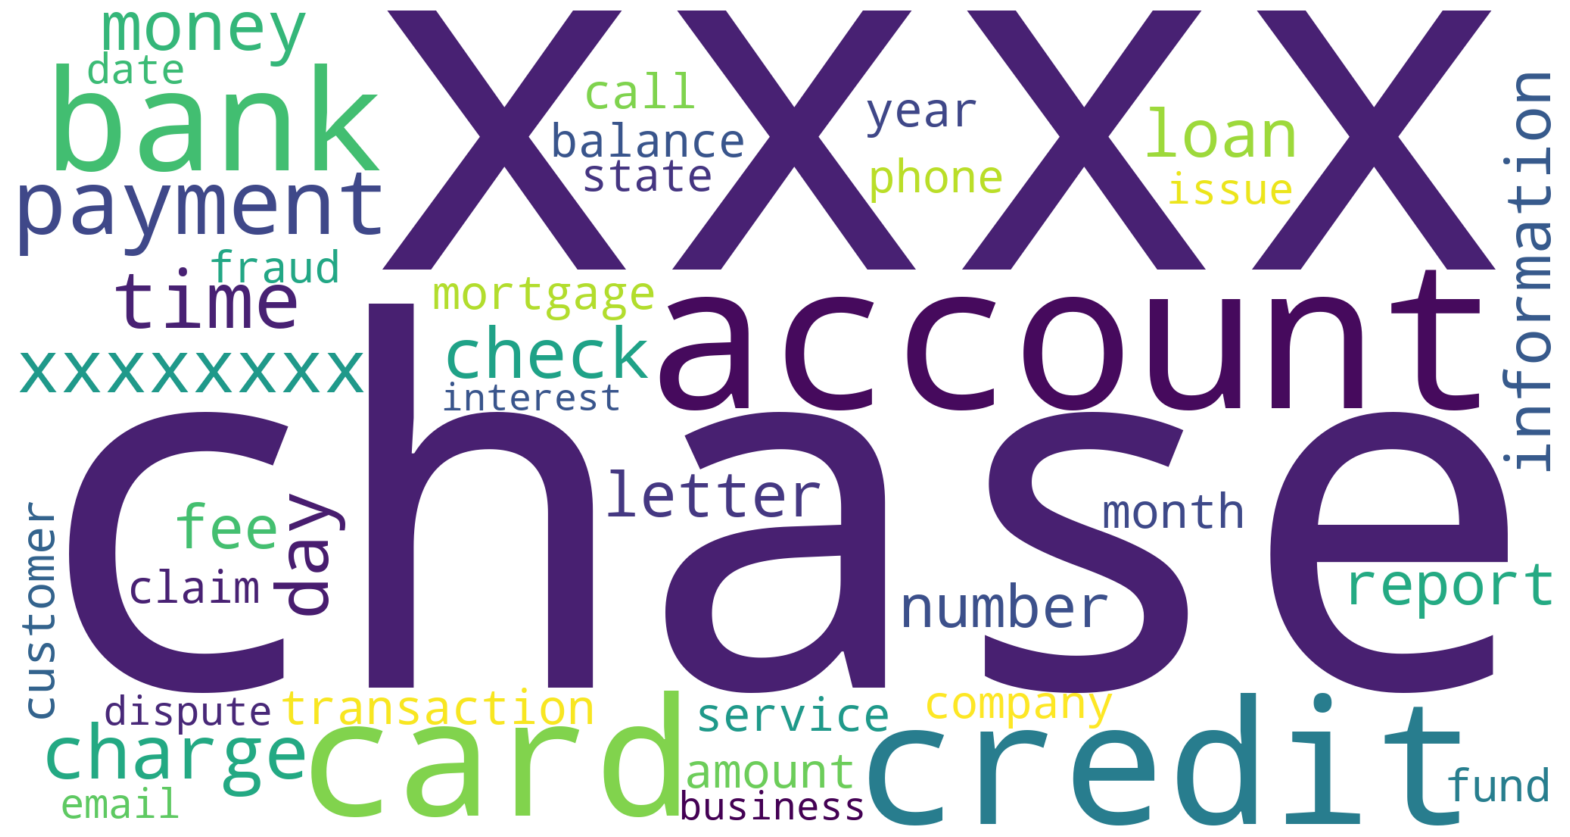

In [227]:
# Creating word cloud for all the words collected from the complaint text.
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
        collocations = False,
        stopwords=stop_words, 
        width = 2048, height = 1080, 
        background_color = 'white',
        max_words=40,
        random_state=42
    ).generate(all_complaint_words)
# Display the generated Word Cloud
plt.figure(figsize=(20, 18))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [209]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [228]:
df_clean.head()

,complaint_text,lammetized_text,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a stat...,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account ...,xxxx card agent anniversary date agent information order account xxxx anniversary date consent recording agent,xxxx card agent anniversary date agent information order account xxxx anniversary date consent recording agent
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a ...,xxxx xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen representative application information xxxx credit offer account s...,xxxx xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen representative application information xxxx credit offer account s...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear...,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number xxxx chase,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number xxxx chase


In [230]:
# Utility function to find the n-grams

def get_top_n_ngrams(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [244]:
def plot_ngram_barplot(ngrams, plot_title, x_label):
    df_unigrams = pd.DataFrame(ngrams, columns = ['ngram' , 'count'])
    plt.figure(figsize=(12,6))
    fig = sns.barplot(x=df_unigrams['ngram'], y=df_unigrams['count'], palette='Spectral', hue=df_unigrams['ngram'])
    plt.xticks(rotation = 80)
    plt.xlabel(x_label)
    plt.title(plot_title)
    plt.show()

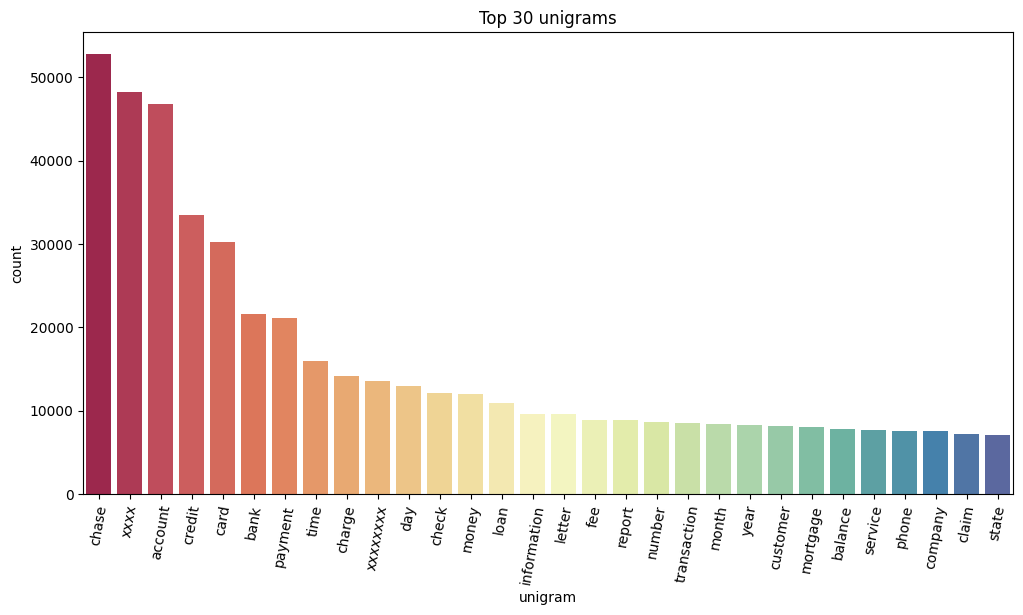

In [249]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_unigrams = get_top_n_ngrams(df_clean['Complaint_clean'], ngram=1, top=30)
plot_ngram_barplot(top_30_unigrams, "Top 30 unigrams", "unigram")

In [248]:
#Print the top 10 words in the unigram frequency
top_30_unigrams[:10]

[('chase', 52752),
 ('xxxx', 48203),
 ('account', 46735),
 ('credit', 33467),
 ('card', 30222),
 ('bank', 21612),
 ('payment', 21161),
 ('time', 16011),
 ('charge', 14154),
 ('xxxxxxxx', 13592)]

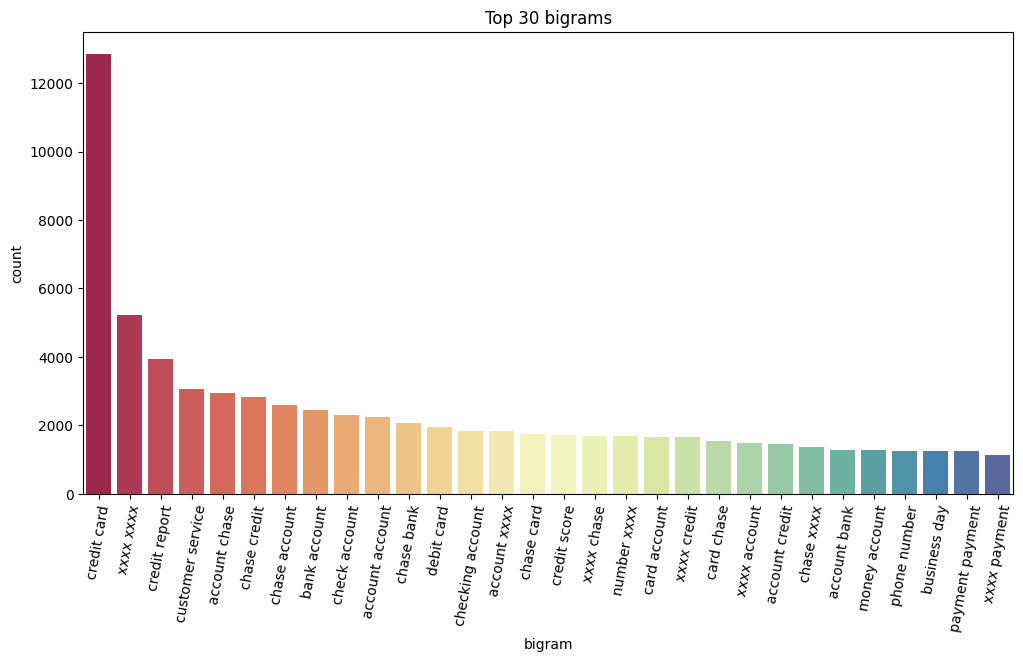

In [250]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

top_30_bigrams = get_top_n_ngrams(df_clean['Complaint_clean'],ngram=2, top=30)
plot_ngram_barplot(top_30_bigrams, "Top 30 bigrams", 'bigram')

In [251]:
#Print the top 10 words in the bigram frequency
top_30_bigrams[:10]

[('credit card', 12852),
 ('xxxx xxxx', 5239),
 ('credit report', 3930),
 ('customer service', 3058),
 ('account chase', 2940),
 ('chase credit', 2825),
 ('chase account', 2601),
 ('bank account', 2441),
 ('check account', 2292),
 ('account account', 2255)]

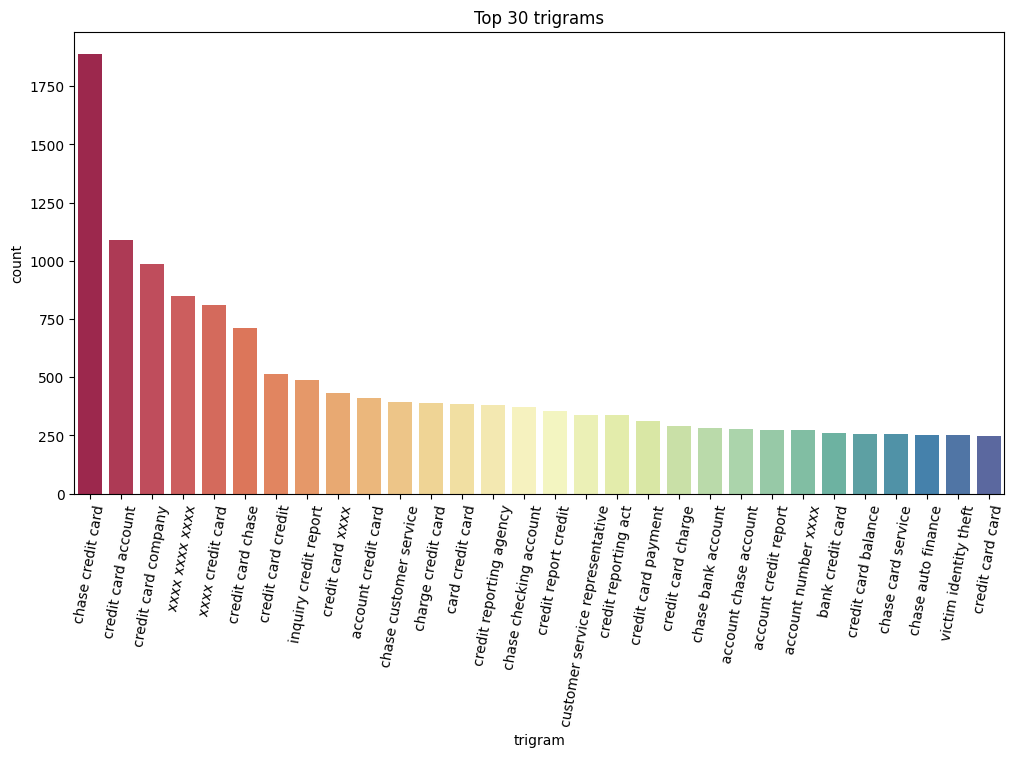

In [252]:
top_30_trigrams = get_top_n_ngrams(df_clean['Complaint_clean'], ngram=3, top=30)

plot_ngram_barplot(top_30_trigrams, "Top 30 trigrams", "trigram")

In [253]:
#Print the top 10 words in the trigram frequency
top_30_trigrams[:10]

[('chase credit card', 1890),
 ('credit card account', 1090),
 ('credit card company', 988),
 ('xxxx xxxx xxxx', 847),
 ('xxxx credit card', 810),
 ('credit card chase', 712),
 ('credit card credit', 512),
 ('inquiry credit report', 489),
 ('credit card xxxx', 430),
 ('account credit card', 410)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [254]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [255]:
#All masked texts has been removed
df_clean.head(10)

,complaint_text,lammetized_text,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent ...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a stat...,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account advance help
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to u...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account ...,xxxx card agent anniversary date agent information order account xxxx anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying th...",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant,chase card report application identity consent service credit identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the off...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a ...,xxxx xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen representative application information xxxx credit offer account s...,ticket offer ticket reward card information offer minute screen decision refer bank chase bank notification screen representative application information credit offer account statement use tic...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son ...,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear...,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number xxxx chase,son chase account fund chase bank account money son check money chase bank money son chase time check owner country time date check number claim number chase
15,Can you please remove inquiry,can you please remove inquiry,inquiry,inquiry
17,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative th...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I go into a branch after be advise by a customer service representative that my account would actually ...,notice account debit card branch customer service representative accoun

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [256]:
#Write your code here to initialise the TfidfVectorizer 

tfidfvectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [257]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix = tfidfvectorizer.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



